# Test using roads as GCP during bundle adjustment

In [ ]:
import os
from glob import glob
import sys

## Define inputs

In [ ]:
data_path = '/bsuhome/raineyaberle/scratch/SkySat-Stereo/study-sites/MCS'
img_list = sorted(glob(os.path.join(data_path, '20240420', 'SkySatScene_TOAR', '*analytic.tif')))
refdem_fn = os.path.join(data_path, '20240420', 'proc_out', 'refdem', 'MCS_refdem_lidar_COPDEM_merged_clipped.tif')
roads_fn = os.path.join(data_path, 'roads', 'MCS_roads_line.shp')
out_dir = os.path.join(data_path, '20240420', 'proc_out')

asp_dir = '/bsuhome/raineyaberle/StereoPipeline-3.5.0-alpha-2024-10-01-x86_64-Linux/bin'

# import workflow functions
# code_path = '/Users/raineyaberle/Research/PhD/SnowDEMs/skysat_snow/'
code_path = '/bsuhome/raineyaberle/scratch/SkySat-Stereo'
sys.path.append(code_path)
import skysat_stereo_workflow_NEW as workflow

## Run initial stereo for dense matches

In [ ]:
init_stereo_dir = os.path.join(out_dir, 'init_stereo')
os.makedirs(init_stereo_dir, exist_ok=True)
camgen_dir = os.path.join(out_dir, 'camgen_cam_gcp')

# Identify overlapping pairs
_ = workflow.identify_overlapping_image_pairs(img_list, overlap_perc=10, utm_epsg="EPSG:32611", out_folder=init_stereo_dir)

stereo_pairs_fn = os.path.join(init_stereo_dir, 'overlapping_image_pairs.txt')

# Run stereo on overlapping pairs
workflow.run_stereo(stereo_pairs_fn=stereo_pairs_fn, 
                    cam_folder=camgen_dir, 
                    out_folder=init_stereo_dir, 
                    session='rpc',
                    texture='normal', 
                    correlator_mode=True)

## Prep GCP using roads and reference DEM

## Mapproject aligned images onto reference DEM

In [21]:
workflow.orthorectify(img_list, 
                      cam_folder=os.path.join(out_path, '..', 'align_photos'),
                      out_folder=out_path,
                      dem=refdem_fn,
                      t_res=1,
                      t_crs="EPSG:32611",
                      orthomosaic=0)

Will run 76 jobs across 4 CPU with 4 threads per CPU

Mapproject arguments for first job:
['--threads', '4', '--tr', '1', '--t_srs', 'EPSG:32611', '--nodata-value', '0', '--ot', 'UInt16', '/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/study-sites/ID-MCS/20240420/proc_out/refdem/MCS_refdem_lidar_COPDEM_merged_clipped.tif', '/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/study-sites/ID-MCS/20240420/SkySatScene_TOAR/20240420_165725_ssc16d1_0006_basic_analytic.tif', '/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/study-sites/ID-MCS/20240420/proc_out/roads_coreg/../align_photos/20240420_165725_ssc16d1_0006_basic_analytic_RPC.TXT', '/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/study-sites/ID-MCS/20240420/proc_out/roads_coreg/20240420_165725_ssc16d1_0006_basic_analytic_map.tif']

Mapping images onto DEM


100%|██████████| 76/76 [48:04<00:00, 37.95s/it]  


Saving compiled orthorectification log at /Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/study-sites/ID-MCS/20240420/proc_out/roads_coreg/ortho.log


## Mosaic aligned, mapprojected images

In [ ]:
# define output file
mosaic_fn = os.path.join(out_path, 'img_mosaic.tif')

# Get mapprojected image file names
img_mp_list = glob(os.path.join(out_path, '*_map.tif'))

# Define gdal_merge arguments
merge_args = img_mp_list + ['-v', '-o', mosaic_fn]

# Run
gdal_merge.main(merge_args)



Processing file     1 of    75,  0.000% completed in 0 minutes.
Filename: /Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/study-sites/ID-MCS/20240420/proc_out/roads_coreg/20240420_165725_ssc16d1_0009_basic_analytic_map.tif
File Size: 2580x1245x4
Pixel Size: 1.000000 x -1.000000
UL:(606521.500000,4868128.500000)   LR:(609101.500000,4866883.500000)
Copy 0,0,2580,1245 to 4146,2240,2580,1245.
Copy 0,0,2580,1245 to 4146,2240,2580,1245.
Copy 0,0,2580,1245 to 4146,2240,2580,1245.
Copy 0,0,2580,1245 to 4146,2240,2580,1245.

Processing file     2 of    75,  1.333% completed in 0 minutes.
Filename: /Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/study-sites/ID-MCS/20240420/proc_out/roads_coreg/20240420_165725_ssc16d1_0007_basic_analytic_map.tif
File Size: 2568x1301x4
Pixel Size: 1.000000 x -1.000000
UL:(606487.500000,4869618.500000)   LR:(609055.500000,4868317.500000)
Copy 0,0,2568,1301 to 4112,750,2568,1301.
Copy 0,0,2568,1301 to 4112,750,2568,1301.
Copy 0,0,2568,1301 to 4112,750

## Coregister mosaic with roads

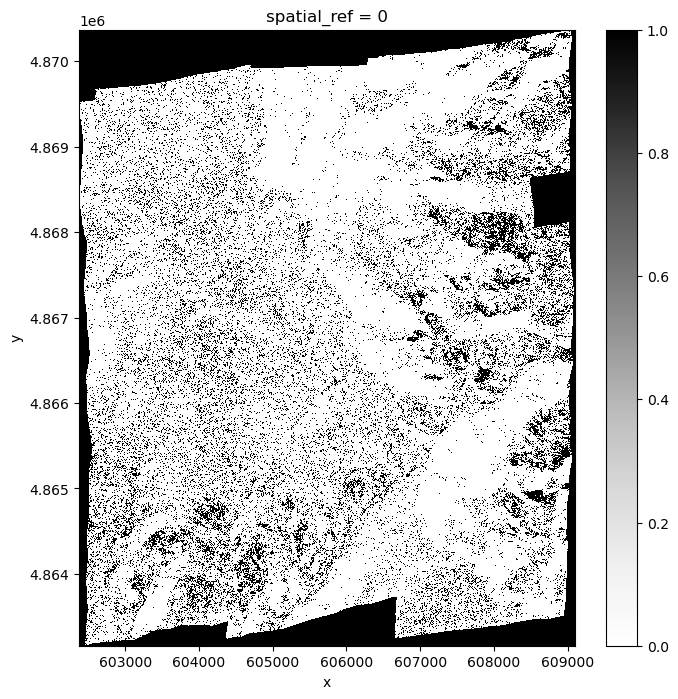

In [22]:
import xarray as xr

mosaic = rxr.open_rasterio(mosaic_fn)
mosaic = mosaic / 1e4

blue = mosaic.isel(band=0)
green = mosaic.isel(band=1)
red = mosaic.isel(band=2)
nir = mosaic.isel(band=3)

# create veg mask
ndvi = (nir - red) / (nir + red)
veg_mask = (ndvi >= 0.1)

# create snow mask
ndsi = (green - nir) / (green + nir)
snow_mask = (ndsi >= 0.1)

# create roads mask
roads_mask = xr.where(~veg_mask & ~snow_mask, True, False)
plt.figure(figsize=(8,8))
roads_mask.plot(cmap='Greys', vmin=0, vmax=1)
plt.show()

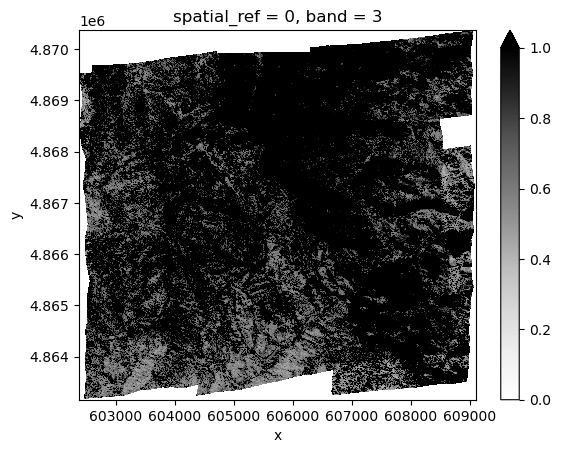

In [23]:
import numpy as np

avg_brightness = np.sqrt((blue**2 + green**2 + red**2))
avg_brightness.plot(cmap='Greys', vmin=0, vmax=1)